In [1]:
# Core libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder,OrdinalEncoder

# Sampling
from imblearn.over_sampling import RandomOverSampler

# Model selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Models
from sklearn.ensemble import RandomForestClassifier

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve
)
import pickle 

In [2]:
df = pd.read_csv("Pakistan Largest Ecommerce Dataset.csv",low_memory=False)
mask_cod= df["payment_method"] == "cod"
mask_stat_net= df["BI Status"] == "Net"
mask_stat_gross= df["BI Status"] == "Gross"
df =df[mask_cod & (mask_stat_net | mask_stat_gross)]

In [3]:
df.head()

,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,sales_commission_code,...,Month,Customer Since,M-Y,FY,Customer ID,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
1,211133.0,canceled,7/1/2016,kcc_Buy 2 Frey Air Freshener & Get 1 Kasual Bo...,240.0,1.0,240.0,100147444,Beauty & Grooming,\N,...,7.0,2016-7,7-2016,FY17,2.0,NaN,NaN,NaN,NaN,NaN
2,211134.0,canceled,7/1/2016,Ego_UP0017-999-MR0,2450.0,1.0,2450.0,100147445,Women's Fashion,\N,...,7.0,2016-7,7-2016,FY17,3.0,NaN,NaN,NaN,NaN,NaN
3,211135.0,complete,7/1/2016,kcc_krone deal,360.0,1.0,60.0,100147446,Beauty & Grooming,R-FSD-52352,...,7.0,2016-7,7-2016,FY17,4.0,NaN,NaN,NaN,NaN,NaN
5,211137.0,canceled,7/1/2016,UK_Namkino All In One 200 Gms,80.0,1.0,80.0,100147448,Soghaat,\N,...,7.0,2016-7,7-2016,FY17,6.0,NaN,NaN,NaN,NaN,NaN
6,211138.0,complete,7/1/2016,kcc_krone deal,360.0,1.0,60.0,100147449,Beauty & Grooming,\N,...,7.0,2016-7,7-2016,FY17,7.0,NaN,NaN,NaN,NaN,NaN


In [4]:
dropcol= ['item_id', 'status',  'sku', 
        'increment_id',
        'payment_method', "M-Y",
       'Working Date', 'Year',  'Customer Since',"Customer ID",
        'FY',  'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',"sales_commission_code",
       'Unnamed: 24', 'Unnamed: 25']


In [5]:
df.drop(columns=dropcol ,inplace = True)

In [6]:
df.head()

,created_at,price,qty_ordered,grand_total,category_name_1,discount_amount,BI Status,MV,Month
1,7/1/2016,240.0,1.0,240.0,Beauty & Grooming,0.0,Gross,240,7.0
2,7/1/2016,2450.0,1.0,2450.0,Women's Fashion,0.0,Gross,"2,450",7.0
3,7/1/2016,360.0,1.0,60.0,Beauty & Grooming,300.0,Net,360,7.0
5,7/1/2016,80.0,1.0,80.0,Soghaat,0.0,Gross,80,7.0
6,7/1/2016,360.0,1.0,60.0,Beauty & Grooming,300.0,Net,360,7.0


In [7]:
df["status"]=df["BI Status"] 
df.drop(columns="BI Status",inplace =True)

In [8]:
df.head()

,created_at,price,qty_ordered,grand_total,category_name_1,discount_amount,MV,Month,status
1,7/1/2016,240.0,1.0,240.0,Beauty & Grooming,0.0,240,7.0,Gross
2,7/1/2016,2450.0,1.0,2450.0,Women's Fashion,0.0,"2,450",7.0,Gross
3,7/1/2016,360.0,1.0,60.0,Beauty & Grooming,300.0,360,7.0,Net
5,7/1/2016,80.0,1.0,80.0,Soghaat,0.0,80,7.0,Gross
6,7/1/2016,360.0,1.0,60.0,Beauty & Grooming,300.0,360,7.0,Net


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 170202 entries, 1 to 584496
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   created_at       170202 non-null  object 
 1   price            170202 non-null  float64
 2   qty_ordered      170202 non-null  float64
 3   grand_total      170202 non-null  float64
 4   category_name_1  170101 non-null  object 
 5   discount_amount  170202 non-null  float64
 6    MV              170202 non-null  object 
 7   Month            170202 non-null  float64
 8   status           170202 non-null  object 
dtypes: float64(5), object(4)
memory usage: 13.0+ MB


In [10]:
df.columns = df.columns.str.strip()


In [11]:
df['MV'] = pd.to_numeric(df['MV'], errors='coerce')

In [12]:
df['Month'] = pd.to_numeric(df['Month'], errors='coerce')

In [13]:
df["date"]=df["created_at"].str.split('/',expand=True)[0].astype("int")
df.drop(columns="created_at",inplace =True)

In [14]:
df["MV"].isnull().mean() * 100

np.float64(35.43084100069329)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 170202 entries, 1 to 584496
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   price            170202 non-null  float64
 1   qty_ordered      170202 non-null  float64
 2   grand_total      170202 non-null  float64
 3   category_name_1  170101 non-null  object 
 4   discount_amount  170202 non-null  float64
 5   MV               109898 non-null  float64
 6   Month            170202 non-null  float64
 7   status           170202 non-null  object 
 8   date             170202 non-null  int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 13.0+ MB


In [16]:
df = df.drop(columns=['MV'])

In [17]:
df.tail()

,price,qty_ordered,grand_total,category_name_1,discount_amount,Month,status,date
584436,235.0,1.0,1484.0,Health & Sports,0.0,8.0,Gross,8
584447,3300.0,1.0,3550.0,Mobiles & Tablets,0.0,8.0,Gross,8
584455,5499.0,1.0,5749.0,Home & Living,0.0,8.0,Gross,8
584491,44459.0,1.0,44759.0,Mobiles & Tablets,0.0,8.0,Gross,8
584496,1048.0,1.0,1298.0,Men's Fashion,0.0,8.0,Gross,8


In [18]:
d=["discount_amount","grand_total"]

In [19]:
df.drop(columns=d , inplace = True )

In [20]:

df['status']=df['status'].map({'Net': 1, 'Gross': 0}) 

In [21]:
df['status'] = pd.to_numeric(df['status'], errors='coerce').fillna(1).astype(int)

In [22]:
features = ['price', 'qty_ordered', 'Month', 'date', 'category_name_1']
X = df[features]
y = df['status']

In [23]:
df.head()

,price,qty_ordered,category_name_1,Month,status,date
1,240.0,1.0,Beauty & Grooming,7.0,0,7
2,2450.0,1.0,Women's Fashion,7.0,0,7
3,360.0,1.0,Beauty & Grooming,7.0,1,7
5,80.0,1.0,Soghaat,7.0,0,7
6,360.0,1.0,Beauty & Grooming,7.0,1,7


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [25]:
# train_data = X_train.copy()
# train_data['status'] = y_train

In [26]:
# success_series = train_data.groupby('Customer ID')['status'].mean()
# global_mean_success = y_train.mean()

In [27]:
# X_train['customer_success_score'] = X_train['Customer ID'].map(success_series)
# X_test['customer_success_score'] = X_test['Customer ID'].map(success_series)

In [28]:
# X_train['customer_success_score'] = X_train['customer_success_score'].fillna(global_mean_success)
# X_test['customer_success_score'] = X_test['customer_success_score'].fillna(global_mean_success)

In [29]:
# X_train = X_train.drop('Customer ID', axis=1)
# X_test = X_test.drop('Customer ID', axis=1)

In [30]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (237220, 5)


,price,qty_ordered,Month,date,category_name_1
0,447.0,1.0,12.0,12,Beauty & Grooming
1,13998.0,1.0,6.0,6,Superstore
2,6700.0,1.0,11.0,11,Mobiles & Tablets
3,200.0,1.0,2.0,2,Soghaat
4,1000.0,3.0,3.0,3,Superstore


''

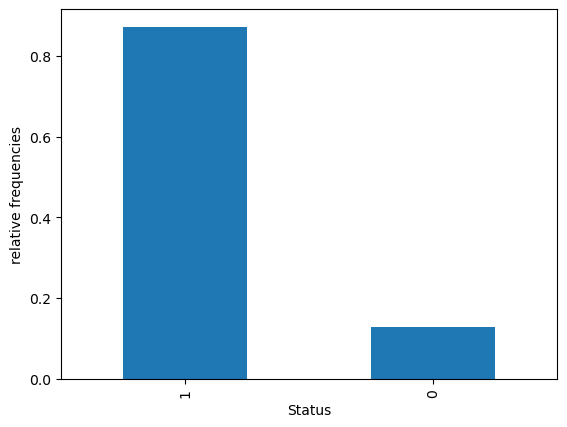

In [31]:
df["status"].value_counts(normalize=True).plot(kind = 'bar',xlabel = "Status",ylabel = "relative frequencies"
                                                     ,title ="")
;

In [32]:
acc_baseline = df['status'].value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.87


In [33]:
num_features = ['price', 'qty_ordered', 'Month','date']
cat_features = ['category_name_1']

In [34]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(), num_features),
        ('cat', make_pipeline(
            SimpleImputer(strategy='most_frequent'),
           OrdinalEncoder()
        ), cat_features)
    ])

In [35]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

In [36]:
# param = {
#     'preprocessor__num__strategy': ['mean', 'median'],
#     'model__min_samples_leaf': [1, 2, 4, 10, 20],
#     'model__n_estimators': [100, 200, 300], # Number of trees,
#     'model__max_depth': range(5, 50), # Anywhere from 5 to 49 deep
   
# }




In [37]:
param = {
    # You already proved 'mean' wins, so let's save compute time and lock it in
    'preprocessor__num__strategy': ['mean'],
    
    # The new Secret Sauce
    'model__max_features': ['sqrt', 'log2', 0.5], 
    
    # Target the sweet spot around your previous winner (31)
    'model__max_depth': [20, 30, 35, 40, None], 
    
    # Anti-Overfitting Combo
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4], 
    
    # Number of trees (Locking in around the winner to save time)
    'model__n_estimators': [200, 300] 
}

In [38]:
model = RandomizedSearchCV(
    clf,
    param_distributions=param,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)


In [39]:
model.fit(X_train_over, y_train_over)



Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\mujta\anaconda3\envs\clean_ds\Lib\site-packages\sklearn\externals\_numpydoc\docscrape.py:420: UserWarning: Unknown section Example
  self[section] = content


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'model__max_depth': [20, 30, ...], 'model__max_features': ['sqrt', 'log2', ...], 'model__min_samples_leaf': [1, 2, ...], 'model__min_samples_split': [2, 5, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",20
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation st

In [40]:
print("Best Depth:", model.best_params_)

Best Depth: {'preprocessor__num__strategy': 'mean', 'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': 35}


In [41]:
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num__strategy,param_model__n_estimators,param_model__min_samples_split,param_model__min_samples_leaf,param_model__max_features,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,82.070274,4.525639,3.472249,0.295409,mean,300,2,1,log2,35,"{'preprocessor__num__strategy': 'mean', 'model...",0.833635,0.835048,0.837155,0.833846,0.830642,0.834065,0.002120,1
17,56.162495,3.824551,2.352338,0.110642,mean,200,5,1,0.5,35,"{'preprocessor__num__strategy': 'mean', 'model...",0.831907,0.833952,0.836270,0.833087,0.830390,0.833121,0.001977,2
14,82.770796,7.273492,4.050723,0.831917,mean,300,5,1,sqrt,40,"{'preprocessor__num__strategy': 'mean', 'model...",0.831738,0.833699,0.836038,0.833066,0.830073,0.832923,0.001993,3
10,98.859370,7.289287,3.465700,0.105929,mean,300,5,1,log2,40,"{'preprocessor__num__strategy': 'mean', 'model...",0.831738,0.833699,0.836038,0.833066,0.830073,0.832923,0.001993,3
2,81.430914,6.292561,3.512676,0.317305,mean,300,2,2,log2,30,"{'preprocessor__num__strategy': 'mean', 'model...",0.825099,0.827945,0.829715,0.827270,0.823961,0.826798,0.002049,5
19,45.774218,2.325306,1.780164,0.089363,mean,200,2,2,sqrt,30,"{'preprocessor__num__strategy': 'mean', 'model...",0.825099,0.827966,0.829589,0.827207,0.823982,0.826768,0.002006,6
1,60.167706,6.988950,2.578426,0.227371,mean,200,5,2,sqrt,35,"{'preprocessor__num__strategy': 'mean', 'model...",0.824825,0.827544,0.829125,0.827270,0.823223,0.826397,0.002101,7
6,75.299408,3.199364,3.642615,0.343273,mean,300,10,2,0.5,40,"{'preprocessor__num__strategy': 'mean', 'model...",0.819893,0.822865,0.825837,0.822528,0.818207,0.821866,0.002626,8
5,72.789758,2.805979,3.354369,0.246538,mean,300,10,2,log2,35,"{'preprocessor__num__strategy': 'mean', 'model...",0.819893,0.823012,0.825352,0.822528,0.818228,0.821803,0.002491,9
12,78.903809,3.234104,3.134920,0.181530,mean,300,10,2,sqrt,None,"{'preprocessor__num__strategy': 'mean', 'model...",0.820019,0.822802,0.825563,0.822591,0.818017,0.821798,0.002579,10


In [42]:
acc_train = model.score(X_train,y_train)
acc_train_over = model.score(X_train_over,y_train_over)
acc_test = model.score(X_test,y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Training_over Accuracy:", round(acc_train_over, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.8448
Training_over Accuracy: 0.861
Validation Accuracy: 0.7718


In [43]:
print(classification_report(y_test,model.predict(X_test)))  

              precision    recall  f1-score   support

           0       0.29      0.56      0.38      4253
           1       0.93      0.80      0.86     29788

    accuracy                           0.77     34041
   macro avg       0.61      0.68      0.62     34041
weighted avg       0.85      0.77      0.80     34041



In [44]:
print("--- THE TRUE CALL CENTER STRATEGY (Risk Score Edition) ---")

call_cost = 20        # PKR cost to call a flagged customer
shipping_saved = 200  # PKR saved when a cancellation is caught
thresholds = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]

# THE FIX: Gross is now 1, Net is now 0
label_gross = 0
label_net = 1

# THE FIX: Pull index 1, which is the probability of 1 (Gross/Cancel)
y_pred_proba = model.predict_proba(X_test)[:, 1]

for t in thresholds:
    y_predict = np.where(y_pred_proba > t, label_gross, label_net)
    
    # THE FIX: Force the matrix to put Gross (1) in the Top-Left (True Negatives)
    conf_matrix = confusion_matrix(y_test, y_predict, labels=[label_net, label_gross])
    
    # Unpack the matrix (tn = Caught Cancellations, fn = Good Customers Blocked)
    tn, fp, fn, tp = conf_matrix.ravel()
    
    total_calls_made = tn + fn 
    
    cost_of_calls = total_calls_made * call_cost
    money_saved = tn * shipping_saved
    net_profit = money_saved - cost_of_calls
    
    print(f"Threshold {t*100:.0f}% -> Flagged: {total_calls_made} | Saved: PKR {money_saved:,} | Call Cost: PKR {cost_of_calls:,} | NET PROFIT: PKR {net_profit:,}")

--- THE TRUE CALL CENTER STRATEGY (Risk Score Edition) ---
Threshold 10% -> Flagged: 2026 | Saved: PKR 177,200 | Call Cost: PKR 40,520 | NET PROFIT: PKR 136,680
Threshold 20% -> Flagged: 3325 | Saved: PKR 358,600 | Call Cost: PKR 66,500 | NET PROFIT: PKR 292,100
Threshold 30% -> Flagged: 4772 | Saved: PKR 584,800 | Call Cost: PKR 95,440 | NET PROFIT: PKR 489,360
Threshold 40% -> Flagged: 6455 | Saved: PKR 860,000 | Call Cost: PKR 129,100 | NET PROFIT: PKR 730,900
Threshold 50% -> Flagged: 8280 | Saved: PKR 1,179,400 | Call Cost: PKR 165,600 | NET PROFIT: PKR 1,013,800
Threshold 60% -> Flagged: 10425 | Saved: PKR 1,560,600 | Call Cost: PKR 208,500 | NET PROFIT: PKR 1,352,100
Threshold 70% -> Flagged: 12678 | Saved: PKR 1,957,000 | Call Cost: PKR 253,560 | NET PROFIT: PKR 1,703,440
Threshold 80% -> Flagged: 15187 | Saved: PKR 2,420,000 | Call Cost: PKR 303,740 | NET PROFIT: PKR 2,116,260
Threshold 90% -> Flagged: 18160 | Saved: PKR 2,969,000 | Call Cost: PKR 363,200 | NET PROFIT: PKR 2,6

In [45]:
print("--- THE TRUE CALL CENTER STRATEGY (Risk Score Edition) ---")

call_cost = 20        # PKR cost to call a flagged customer
shipping_saved = 200  # PKR saved when a cancellation is caught
thresholds = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]

# Extract the probability of 0 (Gross / Cancellation Risk)
y_pred_proba_risk = model.predict_proba(X_test)[:, 0] 

for t in thresholds:
    # If the risk probability is higher than our threshold, predict 0 (Gross), otherwise 1 (Net)
    y_predict = np.where(y_pred_proba_risk > t, 0, 1) 
    
    # Standard matrix: 0 is Gross, 1 is Net
    cm = confusion_matrix(y_test, y_predict, labels=[0, 1])
    
    # Explicitly unpack the matrix by coordinates so the math never breaks
    caught_cancellations = cm[0, 0]           # Actual 0, Predicted 0
    missed_cancellations = cm[0, 1]           # Actual 0, Predicted 1
    wrongly_flagged_good_customers = cm[1, 0] # Actual 1, Predicted 0
    good_customers_untouched = cm[1, 1]       # Actual 1, Predicted 1
    
    # We call everyone we PREDICTED as 0 (Caught + Wrongly Flagged)
    total_calls_made = caught_cancellations + wrongly_flagged_good_customers 
    
    cost_of_calls = total_calls_made * call_cost
    money_saved = caught_cancellations * shipping_saved # Only save shipping on the bad ones we actually caught
    net_profit = money_saved - cost_of_calls
    
    print(f"Threshold {t*100:.0f}% -> Flagged: {total_calls_made} | Saved: PKR {money_saved:,} | Call Cost: PKR {cost_of_calls:,} | NET PROFIT: PKR {net_profit:,}")

--- THE TRUE CALL CENTER STRATEGY (Risk Score Edition) ---
Threshold 10% -> Flagged: 18153 | Saved: PKR 662,600 | Call Cost: PKR 363,060 | NET PROFIT: PKR 299,540
Threshold 20% -> Flagged: 15186 | Saved: PKR 617,400 | Call Cost: PKR 303,720 | NET PROFIT: PKR 313,680
Threshold 30% -> Flagged: 12677 | Saved: PKR 578,600 | Call Cost: PKR 253,540 | NET PROFIT: PKR 325,060
Threshold 40% -> Flagged: 10425 | Saved: PKR 524,400 | Call Cost: PKR 208,500 | NET PROFIT: PKR 315,900
Threshold 50% -> Flagged: 8280 | Saved: PKR 476,600 | Call Cost: PKR 165,600 | NET PROFIT: PKR 311,000
Threshold 60% -> Flagged: 6455 | Saved: PKR 431,000 | Call Cost: PKR 129,100 | NET PROFIT: PKR 301,900
Threshold 70% -> Flagged: 4771 | Saved: PKR 369,600 | Call Cost: PKR 95,420 | NET PROFIT: PKR 274,180
Threshold 80% -> Flagged: 3325 | Saved: PKR 306,400 | Call Cost: PKR 66,500 | NET PROFIT: PKR 239,900
Threshold 90% -> Flagged: 2024 | Saved: PKR 227,800 | Call Cost: PKR 40,480 | NET PROFIT: PKR 187,320


Class Order: [0 1]


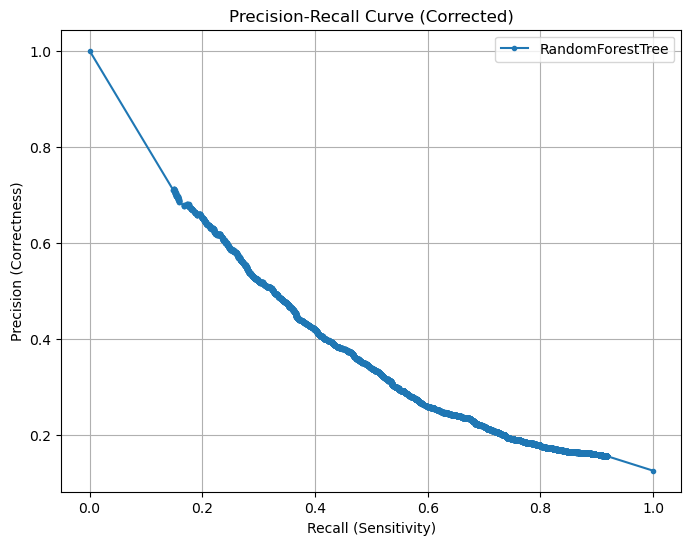

In [46]:
print("Class Order:", model.classes_) 



y_proba_gross = model.predict_proba(X_test)[:, 0]


precision, recall, thresholds = precision_recall_curve(y_test, y_proba_gross, pos_label=0)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='RandomForestTree')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (Correctness)')
plt.title('Precision-Recall Curve (Corrected)')
plt.legend()
plt.grid()
plt.show()

In [47]:
preprocessor = model.best_estimator_.steps[0][1]
raw_names = preprocessor.get_feature_names_out()


In [48]:
clean_names = []
for name in raw_names:
    
    clean_name = name.split('__')[-1]
    if clean_name == '0':
        
        clean_name = 'category_name_1'
    clean_names.append(clean_name)

In [49]:
importances = model.best_estimator_.steps[-1][1].feature_importances_
feat_imp = pd.DataFrame({'feature': clean_names, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=True)


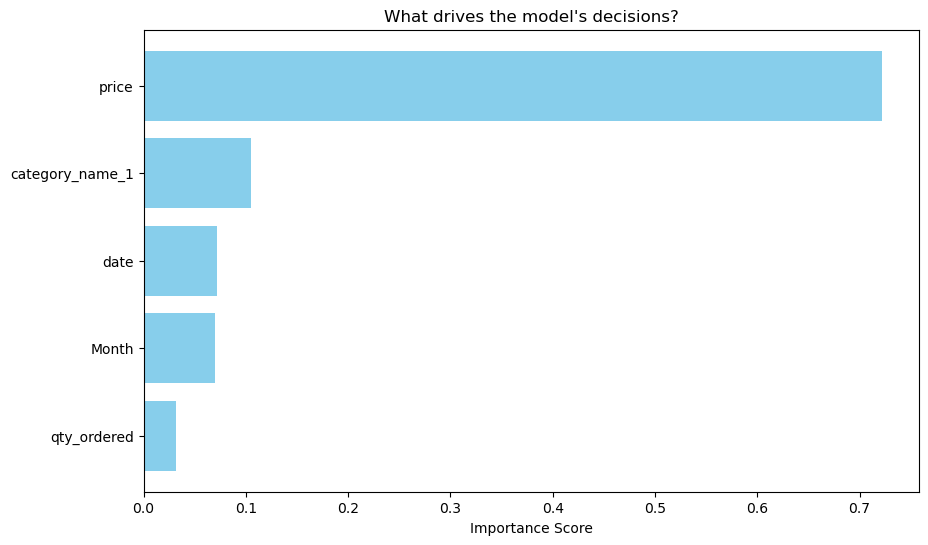

In [50]:
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'], feat_imp['importance'], color='skyblue')
plt.title("What drives the model's decisions?")
plt.xlabel("Importance Score")
plt.show()

In [51]:
with open("ecom daraz.pkl" , "wb") as f:
    pickle.dump(model,f)